<a href="https://colab.research.google.com/github/CFVV/MSc-assignments/blob/main/T2_Automatic_gender_recognition_(male-female).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tarea 02: Reconocedor de Género
## Curso Reconocimiento de Patrones

Departamento de Ciencia de la Computación

Pontificia Universidad Católica de Chile

Camila F. Vera Villa


#Descripción
El objetivo de esta tarea es diseñar un reconocedor automático de género (hombre/mujer) usando extracción de características (por ejemplo textura, geometría, etc.), seleccionador de caracteristicas y clasificador KNN.


# Objetivo

Se debe disenar un clasificador que funcione con un **máximo de 12 caracerísticas**, para esto se deben sacar al menos 200 características y a partir de técnicas se selección y/o transformación de características se le debe proporcionar al clasificador un máximo de 12 características. Está permitido por ejemplo una estrategia que:

a) extraiga 1000 características

b) seleccione 100

c) realice una transformación (tipo PCA, PLSR, etc.) de esas 100 para obtener 12

d) se clasifique con las 12 características obtenidas en c).


Todas las combinaciones de transformación y selección, en cualquier orden están permitidas... la restricción es que el clasificador debe recibir como máximo 12 características.

El clasificador a emplear es un KNN de 3 vecinos.

La base de datos tiene 1400 imágenes y el protocolo de pruebas es el siguiente:
* se usarán las primeras 630 imágenes por clase para training (nnnn={0001, 0002, ... 630})
* las últimas 70 imágenes para testing (nnnn={0631, 0632, ... 700}).


# 0. Setup Inicial


## Instalación de librerías necesarias

In [ ]:
from IPython.display import clear_output
!pip install opencv-python
#!pip install scipy==1.2
!pip install scipy==1.1.0
!pip3 install pybalu==0.2.5
clear_output()
print('Librerías instaladas.')

Librerías instaladas.


## Importación de librerías necesarias

In [ ]:
import numpy as np
import pandas as pd
import cv2
import PIL
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
from scipy.ndimage.morphology import binary_fill_holes
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from tqdm.auto import tqdm
from pybalu.feature_extraction import lbp_features, haralick_features, gabor_features,hog_features
from pybalu.feature_transformation import normalize, pca
from pybalu.feature_selection import sfs,clean
from pybalu.feature_analysis import jfisher
from pybalu.feature_extraction import fourier_des_features, hugeo_features, flusser_features, gupta_features,basic_geo_features
from mlxtend.feature_selection import SequentialFeatureSelector as mlxsfs
from sklearn.cross_decomposition import PLSRegression
print('Librerías cargadas.')


Librerías cargadas.


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# 1. Carga de datos
Se cuenta con una base de datos de 1400 imágenes de caras en tonos de gris de 165x120 pixeles, correspondientes fotos de hombres y fotos de mujeres, distribuidas 50-50%, es decir 700 imágenes pertencientes a la clase 0 (hombres), y 700 imágenes pertenecientes a la clase 1 (mujeres).

El formato del nombre de la imagen es face_00x_nnnn.png donde x es 1 para hombres y 2 para mujeres, y nnnn es el número de la imagen por clase, es decir 0001, 0002, ... 0700.


In [ ]:
# Descarga de la totalidad de las imágenes desde dropbox
!wget https://www.dropbox.com/s/1xajq6knp1mm34h/argender.zip
clear_output()
print('Imágenes descargadas.')

Imágenes descargadas.


In [ ]:
# Descomprimir la carpeta de imágenes
!unzip argender
!rm argender.zip
clear_output()
print('Base de datos cargada.')

Base de datos cargada.


Funciones necesarias

In [ ]:
# Funciones necesarias para que se pueda cargar una imagen individual

def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  st = '%0*d' % (d,x)
  return st

def ImageLoadColor(prefix,num_char,num_img,echo='off'):
  st   = prefix + num2fixstr(num_char,3) + '_' + num2fixstr(num_img,4) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')
  imgColor = cv2.cvtColor(cv2.imread(st), cv2.COLOR_BGR2RGB) #gray ->  COLOR_BGR2GRAY
  return imgColor

def ImageLoad(prefix,num_char,num_img,echo='off'):
  st   = prefix + num2fixstr(num_char,3) + '_' + num2fixstr(num_img,4) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')
  img    = np.array(plt.imread(st), dtype = np.uint8)
  return img

Visualización de una imagen por cada clase

* Lectura de una imagen de la clase 0: hombre

loading image argender/face_001_0001.png...


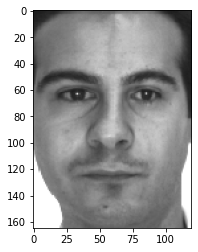

In [ ]:
# Lectura de una imagen para hombre RGB
fig    = plt.figure()
ax     = fig.add_subplot(111)
imgColor    = ImageLoadColor('argender/face_',1,1,echo='on')
implot = plt.imshow(imgColor)

loading image argender/face_001_0001.png...


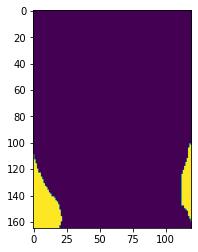

In [ ]:
# Lectura de una imagen para hombre 2D Array
fig    = plt.figure()
ax     = fig.add_subplot(111)
img    = ImageLoad('argender/face_',1,1,echo='on')
implot = plt.imshow(img )


* Lectura de una imagen de la clase 1: mujer

loading image argender/face_002_0288.png...


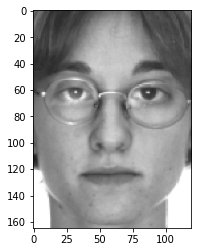

In [ ]:
# Lectura de una imagen mujer RGB
fig    = plt.figure()
ax     = fig.add_subplot(111)
imgColor    = ImageLoadColor('argender/face_',2,288,echo='on')
implot = plt.imshow(imgColor) #,cmap='gray'

loading image argender/face_002_0288.png...


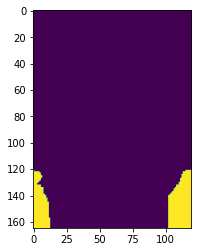

In [ ]:
# Lectura de una imagen mujer 2D Array
fig    = plt.figure()
ax     = fig.add_subplot(111)
img    = ImageLoad('argender/face_',2,288,echo='on')
implot = plt.imshow(img) #,cmap='gray'


# 2. Definición de conjuntos de train y test.

*   Training: primeras 630 imágenes de cada clase
*   Testing: últimas 70 imágenes de cada clase

In [ ]:
# Separación entre training y testing
def SplitTrainTest(X,y,n):

  K      = np.max(y)+1              # número de clases
  N      = np.int(X.shape[0]/K)     # numeros de muestras por clase
  Ntrain = n*K                      # número de muestras para el training
  Ntest  = K*N-Ntrain               # número de muestras para el testing
  M      = X.shape[1]               # número de características por muestra
  Xtrain = np.zeros((Ntrain,M))     # subset de training
  ytrain = np.zeros((Ntrain),'int') # ground truth del training
  Xtest  = np.zeros((Ntest,M))      # subset de testing
  ytest  = np.zeros((Ntest),'int')  # ground truth del testing

  # contadores
  itrain = 0
  itest  = 0
  t      = 0

  for j in range(K):     # para cada clase
    for i in range(N):   # para cada imagen de la clase
      if i<n: # training
        Xtrain[itrain,:] = X[t,:]
        ytrain[itrain] = y[t]
        itrain = itrain+1
      else:  # testing
        Xtest[itest,:] = X[t,:]
        ytest[itest] = y[t]
        itest = itest+1
      t = t+1

  return Xtrain,ytrain,Xtest,ytest


Normalización MinMax: cada columna es normalizada para que tenga minimo 0 y máximo 1

In [ ]:
# Normalización MinMax: cada columna es normalizada para que tenga minimo 0 y máximo 1
def minmax(X):
    ma = X.max(0)
    mi = X.min(0)
    md    = ma-mi
    a     = 1/ md
    b     = -mi/md
    return X * a + b, a, b

# 2. RONDAS DE EXPERIMENTOS

# I. PRIMERA PARTE
## RONDA DE EXPERIMENTOS PARA EXTRACCIÓN DE CARACTERÍSTICAS Y CLASIFICACIÓN

## A. Extracción de características LBP, Haralick, Gabor y HoG
**LBP**:

Se divide la imagen img en a x b particiones y en cada una de ellas se extrae el descriptor LBP (vector de 59 elementos). En este caso f es un vector de 59*a*b elementos. En este caso se considerará a = b = 2, es decir dos particiones por imagen.


```
f = lbp_features(img, hdiv=a, vdiv=b, mapping='nri_uniform')
```
**Haralick**:


Se extrae el vector Haralick para una distancia de `d` pixeles. En este caso `f` es un vector de 28 elementos (independiente de la distancia `d`). En este caso se considerará *d = 3.*

`f = haralick_features(img, distance=d)`

**Gabor**:

Se extrae el vector Gabor para `r` rotaciones y `s` escalas. En este caso `f` es un vector de `r*s+3` elementos. En este caso se considerará  *r = s = 8*.


`f = gabor_features(img, rotations=r, dilations=s)`

**HoG**:

se divide la imagen `img` en `a x b` particiones y en cada una de ellas se extrae el descriptor HoG (vector de `q` elementos, ya que el histograma es de `q` bins). En este caso `f` es un vector de `q*a*b` elementos. En este ejercicio trabajaremos con `a = 16, b = 10` y  `q = 9` bins en el histograma. Es decir 1440 features.

`f = hog_features(img, v_windows=a, h_windows=b, n_bins=q)`




In [ ]:
K    = 2     # NUMERO DE CLASES
N    = 700   # NUMERO DE IMAGENES POR CLASE


hdiv = 2    # número de particiones horizontales
vdiv = 2    # número de particiones verticales
Mlbp = hdiv*vdiv*59    # número de características por imagen
Mhar = 28    # NUMERO DE ELEMENTOS DEL VECTOR DE HARALICK
Mgab = 67    # NUMERO DE ELEMENTOS DEL VECTOR DE GABOR
Mhog = 1440     # NUMERO DE ELEMENTOS DEL VECTOR DE HOG

Xlbp  = np.zeros((K*N,Mlbp))    # K*N muestras (filas), y Mlbp características (columnas)
Xhar  = np.zeros((K*N,Mhar))    # K*N muestras (filas), y Mhar características (columnas)
Xgab  = np.zeros((K*N,Mgab))    # K*N muestras (filas), y Mgab características (columnas)
Xhog  = np.zeros((K*N,Mhog))    # K*N muestras (filas), y Mhog características (columnas)

y     = np.zeros((K*N),'int')   # ground truth (clasificacion ideal)

t = 0
print('Cargando imagenes y extrayendo características...')
for j in range(K):            # para cada clase
  print('Extrayendo características: batch '+str(j+1)+'/'+str(K))
  for i in tqdm(range(N)):                # para cada imagen de la clase
    # Lectura de la imagen
    img    = 255*ImageLoad('argender/face_',j+1,i+1,echo='on')+1e-3

    # Extracción de características
    # HoG
    Xhog[t,:] = hog_features(img, v_windows=16, h_windows=10, n_bins=9)    # <=  EXTRAE HOG

    # LBP  de 2x2 particiones
    Xlbp[t,:] = lbp_features(img, hdiv=hdiv, vdiv=vdiv, mapping='nri_uniform') # <=  EXTRAE LBP
    # Normalización LBP
    Xlbp[t,:] = Xlbp[t,:]/np.linalg.norm(Xlbp[t,:])

    # Haralick con d = 3 pixeles
    Xhar[t,:] = haralick_features(img, distance=3)                       # <= EXTRAE HARALICK
    #Xhar[t,:] = Xhar[t,:]/np.linalg.norm(Xhar[t,:])

    # Gabor con 8 rotaciones y 8 escalas
    Xgab[t,:] = gabor_features(img, rotations=8, dilations=8)            # <= EXTRAE GABOR

    y[t] = j # la muestra t pertenece a la clase j
    t = t+1

Cargando imagenes y extrayendo características...
Extrayendo características: batch 1/2


loading image argender/face_001_0001.png...
loading image argender/face_001_0002.png...
loading image argender/face_001_0003.png...
loading image argender/face_001_0004.png...
loading image argender/face_001_0005.png...
loading image argender/face_001_0006.png...
loading image argender/face_001_0007.png...
loading image argender/face_001_0008.png...
loading image argender/face_001_0009.png...
loading image argender/face_001_0010.png...
loading image argender/face_001_0011.png...
loading image argender/face_001_0012.png...
loading image argender/face_001_0013.png...
loading image argender/face_001_0014.png...
loading image argender/face_001_0015.png...
loading image argender/face_001_0016.png...
loading image argender/face_001_0017.png...
loading image argender/face_001_0018.png...
loading image argender/face_001_0019.png...
loading image argender/face_001_0020.png...
loading image argender/face_001_0021.png...
loading image argender/face_001_0022.png...
loading image argender/face_001_

loading image argender/face_002_0001.png...
loading image argender/face_002_0002.png...
loading image argender/face_002_0003.png...
loading image argender/face_002_0004.png...
loading image argender/face_002_0005.png...
loading image argender/face_002_0006.png...
loading image argender/face_002_0007.png...
loading image argender/face_002_0008.png...
loading image argender/face_002_0009.png...
loading image argender/face_002_0010.png...
loading image argender/face_002_0011.png...
loading image argender/face_002_0012.png...
loading image argender/face_002_0013.png...
loading image argender/face_002_0014.png...
loading image argender/face_002_0015.png...
loading image argender/face_002_0016.png...
loading image argender/face_002_0017.png...
loading image argender/face_002_0018.png...
loading image argender/face_002_0019.png...
loading image argender/face_002_0020.png...
loading image argender/face_002_0021.png...
loading image argender/face_002_0022.png...
loading image argender/face_002_

## B. Clasificación y evaluación

KNN con 3 vecinos

Función que usa *KNeighborsClassifier* para la clasificación, luego retorna la matriz de confusión y evalúa con la métrica de accuracy.

In [ ]:
# Clasificación usando KNN con 3 vecinos
def ClassifierKNN(Xtrain,ytrain,Xtest,ytest, norm = False, distance = 'cosine', p = 2):
  if norm:
    Xtrain, a, b = minmax(Xtrain)
    Xtest        = Xtest * a + b
  knn = KNeighborsClassifier(n_neighbors=3,weights = 'uniform', metric = distance, p = p)
  knn.fit(Xtrain, ytrain)
  ypred        = knn.predict(Xtest)
  acc          = accuracy_score(ytest,ypred)
  print('Entrenando con '+str(Xtrain.shape[0])+' muestras y probando con '+str(Xtest.shape[0])+' muestras')
  print('Los datos tienen '+str(Xtrain.shape[1])+' features')
  print('Testing Accuracy = '+str(acc*100)+'%')
  C = confusion_matrix(ytest,ypred)
  print('Matriz de Confusión:')
  print(C)
  return acc,C

 ## Clasificación usando HOG

Clasificación Hog - 1440 features



In [ ]:
# Paso 1:Se carga en la matriz `X` las características de HoG extraídas anteriormente que van a ser usadas por el clasificador

# Paso 2: separar training/testing
ntrain = 630 # número de muestras por clase para el entrenamiento
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(Xhog,y,ntrain)

# Paso 3: clasificar y evaluar desempeño
acc,Chog = ClassifierKNN(Xtrain,ytrain,Xtest,ytest, norm = False, distance = 'cosine')

Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 1440 features
Testing Accuracy = 82.85714285714286%
Matriz de Confusión:
[[56 14]
 [10 60]]


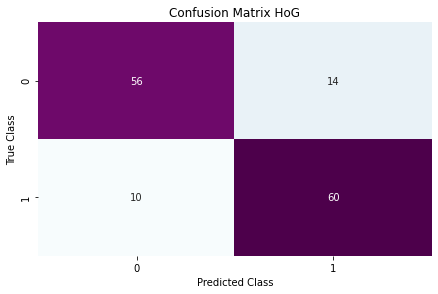

In [ ]:
    sns.heatmap(Chog, annot=True, cbar=None, cmap="BuPu")
    plt.title("Confusion Matrix HoG"), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

* Con HoG se obtuvo un accuracy en el conjunto de test de 82,9%.

Guarda la matriz de HoG

In [ ]:
#np.save('Xhog.npy', Xhog) ## Correr solo si es necesario sobrescribir la matriz

## Clasificación usando LBP

Se transforma la matriz a dataframe para verificar nulos

In [ ]:
df_faces_lbp = pd.DataFrame(Xlbp)
df_faces_lbp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235
0,0.000433,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.017553,0.0,0.0,0.012569,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000433,0.0,0.0,0.000650,0.001300,0.0,0.0,0.0,0.0,0.0,0.012569,0.000217,0.006718,0.0,0.0,0.0,0.013436,0.0,0.0,0.000000,0.000217,0.000433,0.0,0.0,0.000108,0.000325,0.0,0.0,0.000867,0.0,0.000867,0.0,0.0,0.000108,0.491056,0.002492
1,0.000108,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000217,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.017430,0.000000,0.012450,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000433,0.0,0.0,0.000974,0.001083,0.0,0.0,0.0,0.0,0.0,0.012559,0.000000,0.005088,0.0,0.0,0.0,0.013100,0.0,0.0,0.000000,0.000325,0.000325,0.0,0.0,0.000325,0.000325,0.0,0.0,0.000650,0.0,0.000650,0.0,0.0,0.000433,0.493140,0.002274
2,0.000433,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.017549,0.0,0.0,0.012566,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000433,0.0,0.0,0.000650,0.001083,0.0,0.0,0.0,0.0,0.0,0.012566,0.000108,0.005091,0.0,0.0,0.0,0.012782,0.0,0.0,0.000000,0.000217,0.000325,0.0,0.0,0.000325,0.000325,0.0,0.0,0.000650,0.0,0.000650,0.0,0.0,0.000433,0.493527,0.002600
3,0.000325,0.000108,0.0,0.0,0.0,0.000217,0.0,0.000108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.016792,0.000000,0.011483,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000433,0.0,0.0,0.000650,0.001083,0.0,0.0,0.0,0.0,0.0,0.012567,0.000108,0.004008,0.0,0.0,0.0,0.013650,0.0,0.0,0.000000,0.000217,0.000325,0.0,0.0,0.000325,0.000325,0.0,0.0,0.000650,0.0,0.000650,0.0,0.0,0.000217,0.494656,0.001950
4,0.000108,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000324,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000108,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.017078,0.000000,0.012538,0.0,...,0.0,0.0,0.0,0.0,0.000216,0.0,0.0,0.000865,0.001081,0.0,0.0,0.0,0.0,0.0,0.012106,0.000000,0.006701,0.0,0.0,0.0,0.014267,0.0,0.0,0.000216,0.000324,0.000324,0.0,0.0,0.000324,0.000000,0.0,0.0,0.000649,0.0,0.000649,0.0,0.0,0.000216,0.490930,0.002054


  Revisión de datos nulos e imputación en caso de True

In [ ]:
 np.any(np.isinf(Xlbp))
#pd.DataFrame(ytest).isna().sum().sum()

False

Clasificación LBP -  236 features

In [ ]:
# Paso 1:Se carga en la matriz `X` las características de LBP extraídas anteriormente que van a ser usadas por el clasificador

# Paso 2: separar training/testing
ntrain = 630 # número de muestras por clase para el entrenamiento
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(Xlbp,y,ntrain)

# Paso 3: clasificar y evaluar desempeño
acc,Clbp = ClassifierKNN(Xtrain,ytrain,Xtest,ytest, norm = False, distance = 'canberra')

Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 236 features
Testing Accuracy = 90.0%
Matriz de Confusión:
[[62  8]
 [ 6 64]]


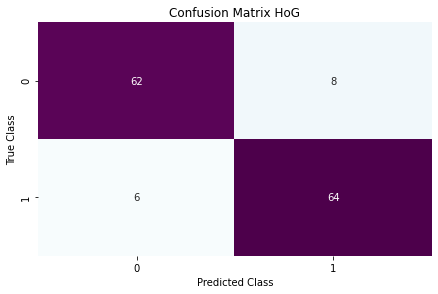

In [ ]:
    sns.heatmap(Clbp, annot=True, cbar=None, cmap="BuPu")
    plt.title("Confusion Matrix HoG"), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

* Con LBP se obtuvo un accuracy en el conjunto de test de 90%.

Guarda la matriz de LBP

In [ ]:
#np.save('Xlbp.npy', Xlbp) ## Correr solo si es necesario sobrescribir la matriz

## Clasificación usando Haralick

Se transforma la matriz a dataframe para verificar nulos

In [ ]:
df_faces_har = pd.DataFrame(Xhar)
df_faces_har.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.904530,0.739369,20.121840,0.739369,0.985213,2.589427,2.363473,0.225954,0.236413,0.120767,0.076527,-0.643069,0.200740,0.986701,0.912352,1.202121,22.784593,1.202121,0.994778,2.606046,2.400276,0.241888,0.258893,0.123486,0.115192,0.840348,0.257866,0.994865
1,0.926858,0.700591,13.465338,0.700591,0.985988,2.426559,2.242738,0.183822,0.193732,0.120982,0.073716,-0.576910,0.145453,0.987748,0.933613,1.049594,15.693415,1.049594,0.994261,2.437638,2.272971,0.195328,0.210175,0.123337,0.103516,0.786966,0.196619,0.994439
2,0.922505,0.740662,14.382880,0.740662,0.985187,2.453150,2.260344,0.192806,0.203283,0.120756,0.077216,-0.575008,0.151375,0.987020,0.929124,1.106468,16.620818,1.106468,0.993382,2.464599,2.290245,0.204869,0.220521,0.123084,0.107921,0.770764,0.201099,0.993617
3,0.919739,0.738723,15.256149,0.738723,0.985226,2.474108,2.275531,0.198578,0.209028,0.120764,0.077426,-0.585254,0.158924,0.986890,0.924898,1.075446,17.010378,1.075446,0.991624,2.483064,2.298571,0.209162,0.224376,0.122579,0.105526,0.731119,0.197027,0.992022
4,0.934299,0.608170,12.172254,0.608170,0.987837,2.384919,2.217079,0.167840,0.176443,0.121506,0.065410,-0.594942,0.139126,0.989372,0.941842,0.941015,14.102476,0.941015,0.996019,2.405139,2.243490,0.175724,0.189035,0.123844,0.094926,0.828226,0.189874,0.996097
5,0.934189,0.581671,12.473155,0.581671,0.988367,2.389628,2.221803,0.167824,0.176052,0.121657,0.062999,-0.612660,0.144037,0.989746,0.940959,0.922919,14.503773,0.922919,0.996277,2.398860,2.250769,0.181553,0.194609,0.123919,0.093470,0.839721,0.195148,0.996338
6,0.922902,0.611401,15.610741,0.611401,0.987772,2.469400,2.279003,0.190396,0.199045,0.121488,0.065721,-0.642986,0.171607,0.988993,0.928953,0.974623,17.830107,0.974623,0.995553,2.482326,2.311216,0.211337,0.225124,0.123710,0.097612,0.837462,0.222022,0.995629
7,0.912052,0.769099,17.368342,0.769099,0.984618,2.527751,2.315381,0.212370,0.223249,0.120600,0.078974,-0.606184,0.176580,0.986424,0.920902,1.196951,20.148671,1.196951,0.995088,2.543632,2.353080,0.224127,0.241059,0.123575,0.114803,0.836567,0.239049,0.995173
8,0.916176,0.764575,16.105157,0.764575,0.984709,2.497191,2.292260,0.204930,0.215746,0.120623,0.078953,-0.591084,0.165633,0.986532,0.924066,1.145246,18.656613,1.145246,0.994209,2.508916,2.326547,0.216287,0.232488,0.123322,0.110888,0.806008,0.222559,0.994357
9,0.911830,0.847301,16.605875,0.847301,0.983054,2.517688,2.303545,0.214143,0.226129,0.120156,0.086078,-0.567374,0.164265,0.985167,0.920049,1.209877,18.992270,1.209877,0.992451,2.536615,2.333592,0.223392,0.236464,0.122816,0.115774,0.765643,0.217451,0.992730


Revisión de datos nulos e imputación en caso de True

In [ ]:
 np.any(np.isinf(df_faces_har))
#df_faces_har = df_faces_har.fillna(method='ffill')

False

Clasificación Haralick - 28 features

In [ ]:
np.isnan(Xtrain).sum()

0

In [ ]:
# Paso 1: Se carga en la matriz `X` las características de Haralick extraídas anteriormente  que van a ser usadas por el clasificador

# Paso 2: separar training/testing
ntrain = 630 # número de muestras por clase para el entrenamiento
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(Xhar,y,ntrain)

# Paso 3: clasificar y evaluar desempeño
acc,Char = ClassifierKNN(Xtrain,ytrain,Xtest,ytest, norm = True, distance = 'manhattan')

Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 28 features
Testing Accuracy = 92.85714285714286%
Matriz de Confusión:
[[62  8]
 [ 2 68]]


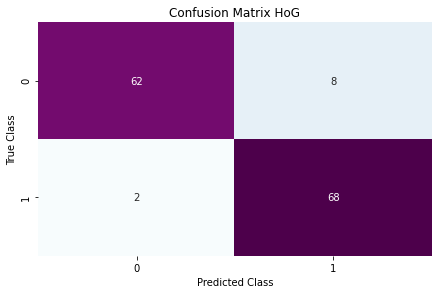

In [ ]:
    sns.heatmap(Char, annot=True, cbar=None, cmap="BuPu")
    plt.title("Confusion Matrix HoG"), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

* Con Haralick se obtuvo un accuracy en el conjunto de test de 92,9%.

Guarda la matriz de Haralick

In [ ]:
#np.save('Xhar.npy', Xhar) ## Correr solo si es necesario sobrescribir la matriz

## Clasificación usando Gabor

Se pasa la matriz a dataframe para verificar nulos

In [ ]:
df_faces_gab = pd.DataFrame(Xgab)
df_faces_gab.isna().sum()

In [ ]:
df_faces_gab.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66
1395,1.279165e-07,7.100772e-08,7.745559e-08,7.099627e-08,1.280771e-07,7.099627e-08,7.745559e-08,7.100772e-08,1.162472e-07,2.746532e-09,1.437103e-07,2.626506e-09,1.165245e-07,2.626506e-09,1.437103e-07,2.746532e-09,1.819736e-07,6.869743e-10,7.603820e-09,5.329920e-10,1.825041e-07,5.329920e-10,7.603820e-09,6.869743e-10,3.411506e-09,1.701142e-10,1.555012e-10,1.772831e-10,3.814460e-09,1.772831e-10,1.556041e-10,1.701142e-10,1.976171e-09,2.782815e-10,2.196626e-10,2.949809e-10,2.657538e-09,2.966415e-10,3.137614e-10,2.799546e-10,3.592792e-09,8.528283e-10,1.378828e-09,9.352386e-10,4.851182e-09,8.919765e-10,2.134706e-09,8.047400e-10,9.306713e-09,3.676265e-09,8.834883e-09,3.873292e-09,1.138138e-08,3.686626e-09,9.841664e-09,3.505263e-09,2.060563e-08,2.794978e-08,2.485327e-08,2.812311e-08,2.360129e-08,2.799086e-08,2.591173e-08,2.782373e-08,1.825041e-07,1.555012e-10,1172.650755
1396,1.279165e-07,7.100772e-08,7.745559e-08,7.099627e-08,1.280771e-07,7.099627e-08,7.745559e-08,7.100772e-08,1.162472e-07,2.746532e-09,1.437103e-07,2.626506e-09,1.165245e-07,2.626506e-09,1.437103e-07,2.746532e-09,1.819736e-07,6.869743e-10,7.603820e-09,5.329920e-10,1.825041e-07,5.329920e-10,7.603820e-09,6.869743e-10,3.411506e-09,1.701142e-10,1.555012e-10,1.772831e-10,3.814460e-09,1.772831e-10,1.556041e-10,1.701142e-10,1.976171e-09,2.782815e-10,2.196626e-10,2.949809e-10,2.657538e-09,2.966415e-10,3.137614e-10,2.799546e-10,3.592792e-09,8.528283e-10,1.378828e-09,9.352386e-10,4.851182e-09,8.919765e-10,2.134706e-09,8.047400e-10,9.306713e-09,3.676265e-09,8.834883e-09,3.873292e-09,1.138138e-08,3.686626e-09,9.841664e-09,3.505263e-09,2.060563e-08,2.794978e-08,2.485327e-08,2.812311e-08,2.360129e-08,2.799086e-08,2.591173e-08,2.782373e-08,1.825041e-07,1.555012e-10,1172.650755
1397,1.279165e-07,7.100772e-08,7.745559e-08,7.099627e-08,1.280771e-07,7.099627e-08,7.745559e-08,7.100772e-08,1.162472e-07,2.746532e-09,1.437103e-07,2.626506e-09,1.165245e-07,2.626506e-09,1.437103e-07,2.746532e-09,1.819736e-07,6.869743e-10,7.603820e-09,5.329920e-10,1.825041e-07,5.329920e-10,7.603820e-09,6.869743e-10,3.411506e-09,1.701142e-10,1.555012e-10,1.772831e-10,3.814460e-09,1.772831e-10,1.556041e-10,1.701142e-10,1.976171e-09,2.782815e-10,2.196626e-10,2.949809e-10,2.657538e-09,2.966415e-10,3.137614e-10,2.799546e-10,3.592792e-09,8.528283e-10,1.378828e-09,9.352386e-10,4.851182e-09,8.919765e-10,2.134706e-09,8.047400e-10,9.306713e-09,3.676265e-09,8.834883e-09,3.873292e-09,1.138138e-08,3.686626e-09,9.841664e-09,3.505263e-09,2.060563e-08,2.794978e-08,2.485327e-08,2.812311e-08,2.360129e-08,2.799086e-08,2.591173e-08,2.782373e-08,1.825041e-07,1.555012e-10,1172.650755
1398,1.279165e-07,7.100772e-08,7.745559e-08,7.099627e-08,1.280771e-07,7.099627e-08,7.745559e-08,7.100772e-08,1.162472e-07,2.746532e-09,1.437103e-07,2.626506e-09,1.165245e-07,2.626506e-09,1.437103e-07,2.746532e-09,1.819736e-07,6.869743e-10,7.603820e-09,5.329920e-10,1.825041e-07,5.329920e-10,7.603820e-09,6.869743e-10,3.411506e-09,1.701142e-10,1.555012e-10,1.772831e-10,3.814460e-09,1.772831e-10,1.556041e-10,1.701142e-10,1.976171e-09,2.782815e-10,2.196626e-10,2.949809e-10,2.657538e-09,2.966415e-10,3.137614e-10,2.799546e-10,3.592792e-09,8.528283e-10,1.378828e-09,9.352386e-10,4.851182e-09,8.919765e-10,2.134706e-09,8.047400e-10,9.306713e-09,3.676265e-09,8.834883e-09,3.873292e-09,1.138138e-08,3.686626e-09,9.841664e-09,3.505263e-09,2.060563e-08,2.794978e-08,2.485327e-08,2.812311e-08,2.360129e-08,2.799086e-08,2.591173e-08,2.782373e-08,1.825041e-07,1.555012e-10,1172.650755
1399,1.279165e-07,7.100772e-08,7.745559e-08,7.099627e-08,1.280771e-07,7.099627e-08,7.745559e-08,7.100772e-08,1.162472e-07,2.746532e-09,1.437103e-07,2.626506e-09,1.165245e-07,2.626506e-09,1.437103e-07,2.746532e-09,1.819736e-07,6.869743e-10,7.603820e-09,5.329920e-10,1.825041e-07,5.329920e-10,7.603820e-09,6.86

In [ ]:
pd.DataFrame(Xgab).isnull().any().sum()
#df_faces_gab = df_faces_gab.fillna(method='ffill')

0

Clasificación Gabor - 67 features

In [ ]:
# Paso 1: Xgab carga en la matriz `X` las características de Gabor extraídas anteriormente  que van a ser usadas por el clasificador

# Paso 2: separar training/testing
ntrain = 630 # número de muestras por clase para el entrenamiento
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(Xgab,y,ntrain)
# Paso 3: clasificar y evaluar desempeño
acc,Cgab = ClassifierKNN(Xtrain,ytrain,Xtest,ytest, norm = False, distance = 'chebyshev')

Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 67 features
Testing Accuracy = 92.14285714285714%
Matriz de Confusión:
[[59 11]
 [ 0 70]]


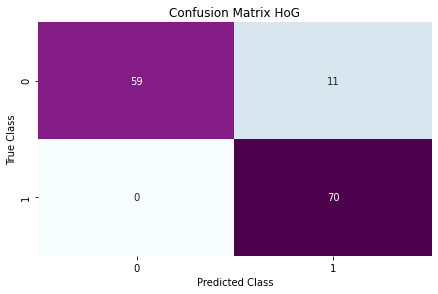

In [ ]:
    sns.heatmap(Cgab, annot=True, cbar=None, cmap="BuPu")
    plt.title("Confusion Matrix HoG"), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

* Con Gabor se obtuvo un accuracy en el conjunto de test de 92,14%.

Guarda la matriz de Gabor

In [ ]:
#np.save('Xgab.npy', Xgab) ## Correr solo si es necesario sobrescribir la matriz

### Desempeño en la clasificación por cada descriptor por separado:

| Descriptor | Accuracy  en el conjunto de test |
|------------|:--------------------------------:|
| HoG        | 82,9%                            |
| LBP        | 90,0%                            |
| Haralick   | 92,9%                            |
| Gabor      | 92,1%                            |

El mejor descriptor corresponde a Haralick con 92,9% de accuracy en el conjunto de test, seguido por Gabor con 92,1%.

## Clasificación usando las características LBP, Haralick y Gabor.

Carga de las matrices de numpy creadas anteriormente

In [ ]:
#Xgab= np.load("Xgab.npy")
#Xhar= np.load("Xhar.npy")
#Xlbp= np.load("Xlbp.npy")

Concatenación de las 3 matrices anteriores: LBP, Haralick y Gabor

In [ ]:
X_Concat = np.concatenate((Xlbp,Xhar,Xgab),axis =1) #concatenación de LBP, Haralick y Gabor

Clasificación con la matriz concatenada - 331 features

In [ ]:
# Conjuntos de train y test
ntrain = 630
Xtrain_concat,ytrain,Xtest_concat,ytest = SplitTrainTest(X_Concat,y,ntrain)

#Clasificación y evaluación
acc,Call = ClassifierKNN(Xtrain_concat,ytrain,Xtest_concat,ytest, distance = "manhattan")

Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 331 features
Testing Accuracy = 90.71428571428571%
Matriz de Confusión:
[[58 12]
 [ 1 69]]


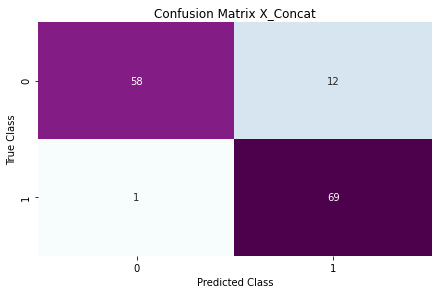

In [ ]:
    sns.heatmap(Call, annot=True, cbar=None, cmap="BuPu")
    plt.title("Confusion Matrix X_Concat"), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

**Comentario**: no se mejoró el accuracy (90,7%) usando todas las características, el mejor desempeño individual hasta el momento es clasificando solo la matriz de Haralick, con 28 features, obteniendo un 92.9% de accuracy.

# II. SEGUNDA PARTE
## RONDA DE EXPERIMENTOS PARA SELECCIÓN DE CARACTERÍSTICAS Y CLASIFICACIÓN

La estrategia consistirá en tomar la matriz concatenada  `X_Concat` resultante de la primera ronda de experimentos que incluye los features de las matrices `Xlbp,Xhar,Xgab `(LBP, Haralick y Gabor respectivamente). Luego se le realizará limpieza o **cleaning** con el módulo "clean" de la librería PyBalu, **normalización**  y por último **selección de atributos**. Para la selección de atributos se probará con *Sequential Forward Selection* (*SFS*) de las librerías *mlxtend* y *PyBalu* para ver si existen diferencias, también se iterará con *Partial least squares regression*  *(PLSR)* de la librería sklearn.

## A. Extracción y selección de características

Se tomará la matriz de características  `X_Concat` de la primera ronda de experimentos, correspondiente  a LBP, Haralick y Gabor.



### Cleaning de características

In [ ]:
sclean_concat = clean(Xtrain_concat)            # índice de características seleccionadas
Xtrain_clean_concat = Xtrain_concat[:,sclean_concat]   # nuevo training
Xtest_clean_concat  = Xtest_concat[:,sclean_concat]    # nuevo testing

#print(sclean)
print(sclean_concat.shape)

(260,)


Clasificación luego del cleaning

In [ ]:
acc,C = ClassifierKNN( Xtrain_clean_concat,ytrain,Xtest_clean_concat,ytest)

Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 260 features
Testing Accuracy = 90.0%
Matriz de Confusión:
[[65  5]
 [ 9 61]]


### Normalización

In [ ]:
Xtrain_norm, a, b = normalize(Xtrain_clean_concat)
Xtest_norm        = Xtest_clean_concat * a + b

## B. Clasificación con datos normalizados y evaluación

In [ ]:
acc,Cnorm = ClassifierKNN(Xtrain_norm,ytrain,Xtest_norm,ytest, distance= "manhattan")

Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 260 features
Testing Accuracy = 90.0%
Matriz de Confusión:
[[64  6]
 [ 8 62]]


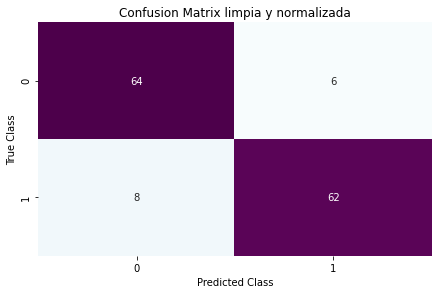

In [ ]:
    sns.heatmap(Cnorm, annot=True, cbar=None, cmap="BuPu")
    plt.title("Confusion Matrix limpia y normalizada"), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

**Comentario**: El desempeño con la matriz concatenada y luego de ser normalizada no mejora el desempeño, manteniéndose con 90% de accuracy. A continuación se probará con selección de características con SFS.

## C.  SFS (Sequential Forward Selection)

SFS es un procedimiento de búsqueda  bottom-up que comienza desde un conjunto vacío y gradualmente agrega características seleccionadas por alguna función de evaluación. En cada
iteración, la característica que se incluirá en el conjunto de características, se selecciona entre las características restantes disponibles de la característica
conjunto, que no se han agregado al conjunto de funciones.

*Referencia: A. Marcano-Cedeño, J. Quintanilla-Domínguez, M. G. Cortina-Januchs and D. Andina, "Feature selection using Sequential Forward Selection and classification applying Artificial Metaplasticity Neural Network," IECON 2010*

### Selección con SFS - Fisher

In [ ]:
def sfs_fisher(X,y,p):
  m = X.shape[1]
  disponibles = np.ones((m,))
  seleccionadas = -np.ones((p,),int)
  Jmax = 0
  for j in tqdm(range(p)):
    for k in range(m):
      if disponibles[k]:
        seleccionadas[j] = k
        columnas = seleccionadas[0:j+1]
        Xsel = X[:,columnas]
        J = jfisher(Xsel,y)
        if J > Jmax:
          Jmax = J
          ksel = k
          print('> selected: J('+str(columnas)+') = '+str(J/100))
    disponibles[ksel] = 0
    seleccionadas[j] = ksel
  return seleccionadas


In [ ]:
# Selección con SFS - Fisher

ss = sfs_fisher(Xtrain_norm,ytrain,12)
Xtrain_sel = Xtrain_norm[:,ss]
Xtest_sel  = Xtest_norm[:,ss]

> selected: J([0]) = 1.395988793463261e-05
> selected: J([5]) = 1.940938099094185e-05
> selected: J([6]) = 2.5992882269309227e-05
> selected: J([7]) = 3.0733770922597554e-05
> selected: J([8]) = 6.552217338899484e-05
> selected: J([10]) = 7.368666269104764e-05
> selected: J([12]) = 8.853880080397859e-05
> selected: J([18]) = 0.00041048873062453454
> selected: J([23]) = 0.00048058072376175174
> selected: J([58]) = 0.006314385139567679
> selected: J([84]) = 0.006660354771749462
> selected: J([87]) = 0.008850175825501494
> selected: J([226]) = 0.0091073047988787
> selected: J([239]) = 0.009158325493439458
> selected: J([246]) = 0.01027834610440141
> selected: J([254]) = 0.010544171257818726
> selected: J([254   0]) = 0.011213636928078207
> selected: J([254   3]) = 0.011281527472873434
> selected: J([254  58]) = 0.012642603854160349
> selected: J([254 215]) = 0.014125513401923015
> selected: J([254 217]) = 0.015444045846808932
> selected: J([254 217   0]) = 0.015447840437592474
> selected:

 Clasificación con 12 caracteristicas seleccionadas

In [ ]:
# Clasificación con 12 caracteristicas seleccionadas

acc,Css = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest, distance= "chebyshev")

Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 12 features
Testing Accuracy = 87.85714285714286%
Matriz de Confusión:
[[58 12]
 [ 5 65]]


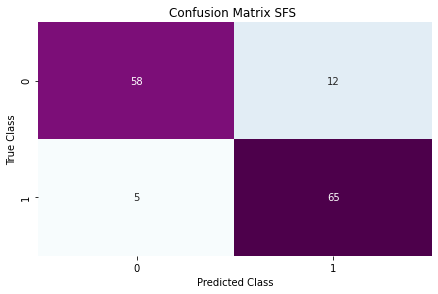

In [ ]:
    sns.heatmap(Css, annot=True, cbar=None, cmap="BuPu")
    plt.title("Confusion Matrix SFS "), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

**comentario**: no mejoró el desempeño con esta técnica de selección.

### SFS (Librería mlxtend)

In [ ]:
estimator = KNeighborsClassifier(n_neighbors=3)
p = 12
forward = True
sfs = mlxsfs(estimator, k_features=p,forward=forward,floating=False,verbose=2,scoring='accuracy',cv=10)

sfs = sfs.fit(Xtrain_norm, ytrain)
sel = list(sfs.k_feature_idx_)

Xtrain_sel = Xtrain_norm[:,sel]
Xtest_sel  = Xtest_norm[:,sel]
acc,Csfs_ml = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    8.6s finished

[2021-05-20 23:48:50] Features: 1/12 -- score: 0.8428571428571429[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 259 out of 259 | elapsed:    6.9s finished

[2021-05-20 23:48:57] Features: 2/12 -- score: 0.8817460317460318[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 258 out of 258 | elapsed:    7.1s finished

[2021-05-20 23:49:04] Features: 3/12 -- score: 0.8952380952380953[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 12 features
Testing Accuracy = 86.42857142857143%
Matriz de Confusión:
[[59 11]
 [ 8 62]]


[Parallel(n_jobs=1)]: Done 249 out of 249 | elapsed:   16.2s finished

[2021-05-20 23:51:00] Features: 12/12 -- score: 0.9166666666666667

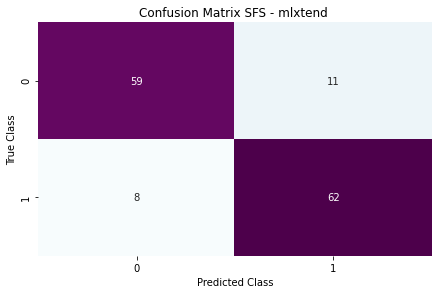

In [ ]:
    sns.heatmap(Csfs_ml, annot=True, cbar=None, cmap="BuPu")
    plt.title("Confusion Matrix SFS - mlxtend "), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

### SFS (Librería PyBalu)

In [ ]:
#Selección con SFS - Fisher
sel = sfs(Xtrain_norm,ytrain,12,show=True)
Xtrain_sel = Xtrain_norm[:,sel]
Xtest_sel  = Xtest_norm[:,sel]

# Clasificación con caracteristicas seleccionadas
print()
print('Datos con SFS:')
print('==============')
acc,C = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest, distance=  "chebyshev")

Selecting Features: 100%|██████████| 12.0/12.0 [00:02<00:00, 4.98 features/s]


Datos con SFS:
Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 12 features
Testing Accuracy = 87.85714285714286%
Matriz de Confusión:
[[58 12]
 [ 5 65]]


**Comentario**: en una primera iteración con SFS de la librería PyBalu, seleccionando 25 features se obtiene un accuracy de 92,14%. En una segunda iteración seleccionando 12 features baja el accuracy a 87,9%

### SFS y PCA (librería PyBalu)

In [ ]:
from   pybalu.feature_selection import sfs
# Primero hacemos una preselección para escoger buenas características
sel_1 = sfs(Xtrain_norm,ytrain,30)
Xtrain_sel_1 = Xtrain_norm[:,sel_1]
Xtest_sel_1  = Xtest_norm[:,sel_1]

# Luego hacemos PCA
Xtrain_pca, _, A, Xm, _ = pca(Xtrain_sel_1, n_components = 12)
Xtest_pca = np.matmul(Xtest_sel_1 - Xm, A) # Paso PCA

# Luego concatenamos y hacemos un nuevo SFS
Xtrain_sfspca = np.concatenate((Xtrain_sel_1,Xtrain_pca),axis=1)
Xtest_sfspca  = np.concatenate((Xtest_sel_1,Xtest_pca),axis=1)

sel_2 = sfs(Xtrain_sfspca,ytrain,12)
Xtrain_sel_2 = Xtrain_sfspca[:,sel_2]
Xtest_sel_2  = Xtest_sfspca[:,sel_2]


acc,Csfs_pca_sfs = ClassifierKNN(Xtrain_sel_2,ytrain,Xtest_sel_2,ytest, distance = 'chebyshev')

Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 12 features
Testing Accuracy = 94.28571428571428%
Matriz de Confusión:
[[62  8]
 [ 0 70]]


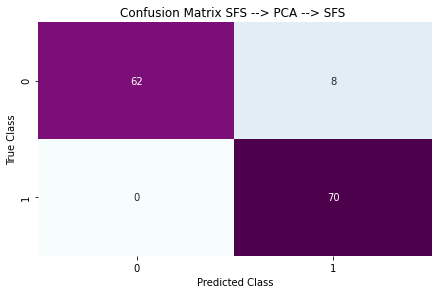

In [ ]:
    sns.heatmap(Csfs_pca_sfs, annot=True, cbar=None, cmap="BuPu")
    plt.title("Confusion Matrix SFS --> PCA --> SFS "), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

**Comentario**: con esta combinación se obtiene el mejor accuracy hasta el momento:` 94,3%, con 12 features` luego de aplicar SFS de 30 características, PCA con n_components =12 y luego SFS de 12 características.

#### **Comentarios desempeño general de SFS**

Con el método SFS, la mejor combinación es utilizando **`SFS-PCA-SFS`** (ambos módulos de la librería PyBalu) obteniendo un accuracy de 94,3% para la matriz concatenada `X_Concat` que incluye las matrices de LBP, Haralick y Gabor, luego de pasar por el cleaning y normalización. La metodología fue utilizar SFS de **30 características**, PCA con **n_components =12** y luego SFS final de **12 características**.

 Se consideraron **12 features** finales para todos los experimentos con SFS.

| Extractor con 12 features     | Accuracy  en  test |
|-------------------------------|:--------------------------------:|
| SFS (Librería mlxtend)        | 86,4%                            |
| SFS (Librería PyBalu)         | 87,9%                            |
| SFS-PCA-SFS (librería PyBalu) | **94,3%**                           |

## D. PLSR (Partial Least Squares Regression)

PLSR es un método para relacionar dos matrices de datos, X e Y, mediante un modelo lineal multivariado, que también modela la estructura de X e Y. PLSR deriva su utilidad de su capacidad para analizar datos con variables ruidosas, numerosas, colineales e incluso incompletas tanto en X como en Y. PLSR tiene la propiedad de que la precisión de los parámetros del modelo mejoran con el número creciente de variables y observaciones relevantes.

*Referencia: Svante Wold, Michael Sjöström, Lennart Eriksson,
PLS-regression: a basic tool of chemometrics, Chemometrics and Intelligent Laboratory Systems,Volume 58, 2001.*

### PLSR

In [ ]:
plsr = PLSRegression(n_components=12)

plsr.fit(Xtrain_norm, ytrain)

Xtrain_plsr = plsr.transform(Xtrain_norm)
Xtest_plsr  = plsr.transform(Xtest_norm)

acc,Cplsr = ClassifierKNN(Xtrain_plsr,ytrain,Xtest_plsr,ytest, distance= "canberra")


Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 12 features
Testing Accuracy = 89.28571428571429%
Matriz de Confusión:
[[55 15]
 [ 0 70]]


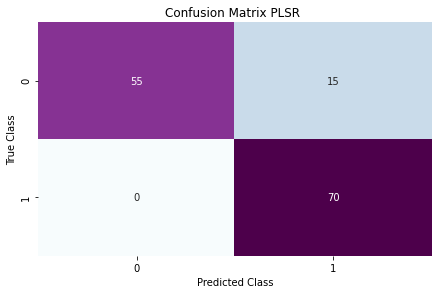

In [ ]:
    sns.heatmap(Cplsr, annot=True, cbar=None, cmap="BuPu")
    plt.title("Confusion Matrix PLSR "), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

### PLSR con HoG

In [ ]:
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(Xhog,y,ntrain)

sclean_hog = clean(Xhog)            # índice de características seleccionadas
Xtrain_clean_hog = Xtrain[:,sclean_hog]   # nuevo training
Xtest_clean_hog  = Xtest[:,sclean_hog]    # nuevo testing

plsr_hog = PLSRegression(n_components=10)

# Normalización MinMax
Xtrain_norm_hog, a, b = minmax(Xtrain_clean_hog)
Xtest_norm_hog        = Xtest_clean_hog * a + b
plsr.fit(Xtrain_norm_hog, ytrain)

Xtrain_plsr_hog = plsr.transform(Xtrain_norm_hog)
Xtest_plsr_hog  = plsr.transform(Xtest_norm_hog)

acc,Cplsr_hog = ClassifierKNN(Xtrain_plsr_hog,ytrain,Xtest_plsr_hog,ytest, distance = 'chebyshev')

Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 12 features
Testing Accuracy = 88.57142857142857%
Matriz de Confusión:
[[61  9]
 [ 7 63]]


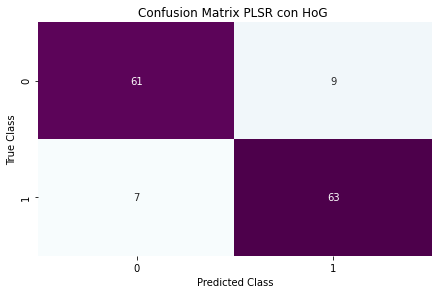

In [ ]:
    sns.heatmap(Cplsr_hog, annot=True, cbar=None, cmap="BuPu")
    plt.title("Confusion Matrix PLSR con HoG "), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

### PLSR con Gabor

In [ ]:
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(Xgab,y,ntrain)

sclean_gab = clean(Xgab)            # índice de características seleccionadas
Xtrain_clean_gab = Xtrain[:,sclean_gab]   # nuevo training
Xtest_clean_gab  = Xtest[:,sclean_gab]    # nuevo testing

plsr_gab = PLSRegression(n_components=10)

# Normalización MinMax
Xtrain_norm_gab, a, b = minmax(Xtrain_clean_gab)
Xtest_norm_gab        = Xtest_clean_gab * a + b
plsr.fit(Xtrain_norm_gab, ytrain)

Xtrain_plsr_gab = plsr.transform(Xtrain_norm_gab)
Xtest_plsr_gab  = plsr.transform(Xtest_norm_gab)

acc,Cplsr_gab = ClassifierKNN(Xtrain_plsr_gab,ytrain,Xtest_plsr_gab,ytest, distance = 'manhattan')

Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 12 features
Testing Accuracy = 92.14285714285714%
Matriz de Confusión:
[[61  9]
 [ 2 68]]


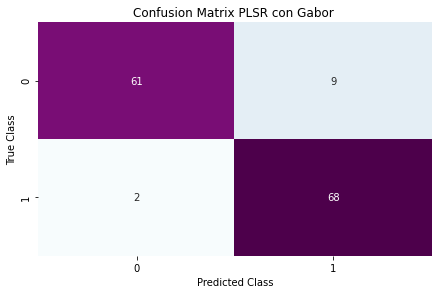

In [ ]:
    sns.heatmap(Cplsr_gab, annot=True, cbar=None, cmap="BuPu")
    plt.title("Confusion Matrix PLSR con Gabor "), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

### PLSR con Haralick

In [ ]:

Xtrain,ytrain,Xtest,ytest = SplitTrainTest(Xhar,y,ntrain)

sclean_har = clean(Xhar)            # índice de características seleccionadas
Xtrain_clean_har = Xtrain[:,sclean_har]   # nuevo training
Xtest_clean_har  = Xtest[:,sclean_har]    # nuevo testing

plsr_har = PLSRegression(n_components=12)

# Normalización MinMax
Xtrain_norm_har, a, b = minmax(Xtrain_clean_har)
Xtest_norm_har        = Xtest_clean_har * a + b
plsr.fit(Xtrain_norm_har, ytrain)

Xtrain_plsr_har = plsr.transform(Xtrain_norm_har)
Xtest_plsr_har  = plsr.transform(Xtest_norm_har)

acc,Cplsr_har = ClassifierKNN(Xtrain_plsr_har,ytrain,Xtest_plsr_har,ytest, distance = 'chebyshev')

Entrenando con 1260 muestras y probando con 140 muestras
Los datos tienen 12 features
Testing Accuracy = 89.28571428571429%
Matriz de Confusión:
[[58 12]
 [ 3 67]]


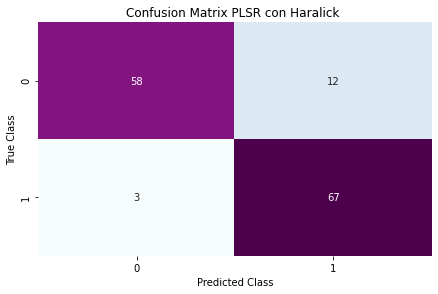

In [ ]:
    sns.heatmap(Cplsr_har, annot=True, cbar=None, cmap="BuPu")
    plt.title("Confusion Matrix PLSR con Haralick "), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

#### Comentarios desempeño general de PLSR

Con el método PLSR, la mejor combinación es utilizando PSLR con la matriz de Gabor **`Xgab`**  obteniendo un accuracy de 92,14%, luego de pasar por el cleaning y normalización. Se consideraron **12 atributos** finales para todos los experimentos con PLSR.


| Extractor con 12 features | Accuracy en test |
|---------------------------|:--------------------------------:|
| PLSR con X_Concat         | 89,3%                            |
| PLSR con HoG              | 88,6%                            |
| PLSR con Gabor            | **92,14%**                          |
| PLSR con Haralick         | 89,3%                            |